In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ephem
from datetime import datetime
import pandas as pd
from astropy.coordinates import Angle

import seaborn as sns

%matplotlib inline

In [2]:
sns.set()
sns.set_context("paper", rc={"lines.linewidth": 1.0})
sns.set_style('white', rc={'axes.linewidth': 0.5})

### Load TLE file and generate pyEphem satellites

In [3]:
tle_filename = 'tles_180301.txt'
#tle_filename = 'tles_180704.txt'
#tle_filename  = 'navstar_180704.txt'
with open(tle_filename) as tle_file:
    tle_data = tle_file.read().splitlines()

sat_list = []
for ii in range(0, len(tle_data), 3):
    sat_list.append(ephem.readtle(*tle_data[ii:ii+3]))

def find_tle(sat_name):
    to_return = []
    for sat in sat_list:
        if sat_name in sat.name:
            to_return.append(sat)
    return to_return

### Create a Parkes ephem observer and a FRB ephem source

In [4]:
# Create FRB ephem source
frb_time =  datetime(2018, 3, 1, 7, 34, 19, 76)
#frb_time = datetime.utcnow()

# Create Ephem observer
pks = ephem.Observer()
pks.lon = '148:15:48.6'
pks.lat = '-32:59:54.3'
pks.date = frb_time

# Preferentially work with astropy Angles
frb_ra   = Angle('6h12m', unit='hourangle')
frb_dec  = Angle('4d33m', unit='degree')

frb = ephem.FixedBody()
frb._ra  = frb_ra.to('radian').value
frb._dec = frb_dec.to('radian').value
frb.compute(pks)
frb_az = Angle(float(frb.az), unit='radian').to('degree')
frb_alt = Angle(float(frb.alt), unit='radian').to('degree')
frb_elev = Angle(90, unit='degree') - frb_alt
print "FRB details:", frb.ra, frb.dec, frb.alt, frb.az
print pks.date

FRB details: 6:12:57.61 4:32:28.4 41:34:04.8 45:26:19.1
2018/3/1 07:34:19


### Load up parkes beams as RA DEC sources

The multi-beam has a 'footprint' on the sky. As they were tracking an RA and DEC, they are fixed on the J2000 sky, but satellites can wander through.

Load in a list of beam locations (from filterbank file headers)

In [5]:
# Beam ID, RA, DEC
beam_locs = [
"1 6:13:45.024 4:58:27.12",
"2 6:14:40.056 4:32:48.12",
"3 6:12:43.392 4:33:45",
"4 6:11:48.288 4:59:23.28",
"5 6:12:49.92  5:24:06.12",
"6 6:14:46.704 5:23:09.24",
"7 6:15:41.736 4:57:29.88",
"8 6:16:37.968 4:31:38.28",
"9 6:13:38.4   4:07:44.04",
"10 6:10:45.432 4:34:30",
"11 6:10:51.84  5:25:13.44",
"12 6:13:51.648 5:49:10.56",
"13 6:16:44.808 5:22:21.72"]

# Loop through and create a beam_dict[1 -- 13] style dictionary.
# Note: beams run 1--13, not 0-12.
beam_dict = {}
for beam_line in beam_locs:
    b_id, b_ra, b_dec = beam_line.split()
    beam = ephem.FixedBody()
    beam._ra  = b_ra
    beam._dec = b_dec
    beam.compute(pks)  
    bb = {
        'ra': Angle(float(beam.ra), unit='radian').to('degree'),
        'dec': Angle(float(beam.dec), unit='radian').to('degree'),
        'az': Angle(float(beam.az), unit='radian').to('degree'),
        'alt': Angle(float(beam.alt), unit='radian').to('degree'),
        'za': Angle(90, unit='degree') - Angle(float(beam.alt), unit='radian').to('degree')
    }
    beam_dict[int(b_id)] = bb

### Compute satelite alt/az positions and create Pandas DataFrame

In [6]:
# Compute satellite locations at each datetime
sat_loc = {
    'alt_rad': np.zeros(len(sat_list)),
    'az_rad': np.zeros(len(sat_list)),
    'za_rad': np.zeros(len(sat_list)),
    'ra_ha': np.zeros(len(sat_list)),
    'dec_deg': np.zeros(len(sat_list)),
    'name': np.empty(len(sat_list), dtype='|S16')
}

for ii, sat in enumerate(sat_list):
    sat.compute(pks)
    sat_loc['za_rad'][ii] = np.pi / 2 - sat.alt
    sat_loc['alt_rad'][ii]  = sat.alt
    sat_loc['az_rad'][ii]   = sat.az
    sat_loc['ra_ha'][ii]    = sat.ra / 2 / np.pi * 24
    sat_loc['dec_deg'][ii]  = sat.dec / np.pi / 2 * 360
    sat_loc['name'][ii]     = sat.name

# Generate a pandas dataframe
df = pd.DataFrame.from_dict(sat_loc)
df = df[['name', 'ra_ha', 'dec_deg', 'az_rad', 'alt_rad', 'za_rad']] # Rearrange columns
df

,name,ra_ha,dec_deg,az_rad,alt_rad,za_rad
0,0 VANGUARD 1,14.439329,-6.043501,2.528404,-0.779205,2.350002
1,0 VANGUARD 2,10.620936,49.904964,0.823559,-0.518558,2.089355
2,0 VANGUARD R/B,14.868261,18.637499,2.225039,-1.195429,2.766225
3,0 VANGUARD R/B,14.279935,27.918554,1.664246,-1.160565,2.731361
4,0 VANGUARD 3,20.110296,42.830613,5.242515,-0.735246,2.306042
5,0 VANGUARD 3,20.110274,42.830653,5.242515,-0.735250,2.306046
6,0 EXPLORER 7,20.093073,-21.676385,4.107558,-0.183738,1.754535
7,0 TRANSIT 2A,17.219720,-8.252492,3.577731,-0.795024,2.365821
8,0 SOLRAD 1 (GREB,19.617127,-25.835813,3.973379,-0.214862,1.785659
9,0 THOR ABLESTAR,4.093451,60.095634,0.004345,-0.032618,1.603414


### Plot satellite locations

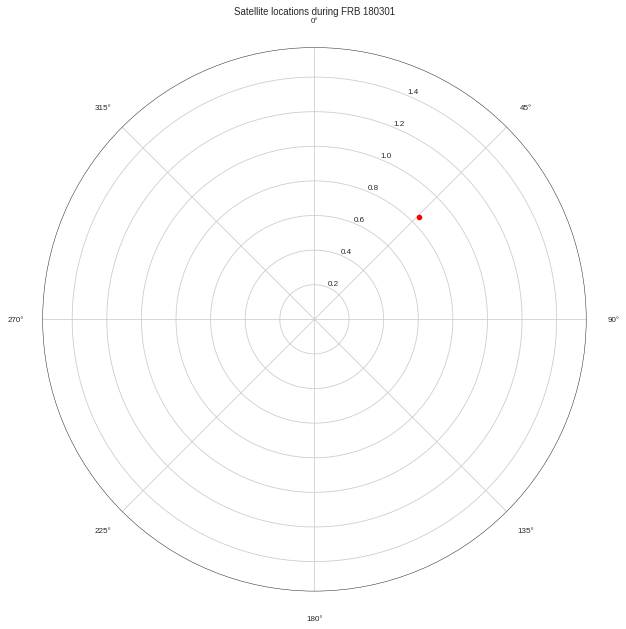

In [7]:
# Plot satellite track in polar coordinates
plt.figure(figsize=(10, 10))
ax = plt.subplot(111,projection='polar')
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
thetagrids = range(0,360,10)

plt.polar(sat_loc['az_rad'], sat_loc['za_rad'], 'x')
plt.polar(frb_az.to('radian').value, frb_elev.to('radian').value, marker='o', color='red')
plt.ylim(0,np.pi/2) # Restrict to above horizon
plt.title("Satellite locations during FRB 180301")

/home/griffin/.local/lib/python2.7/site-packages/matplotlib/projections/geo.py:493: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


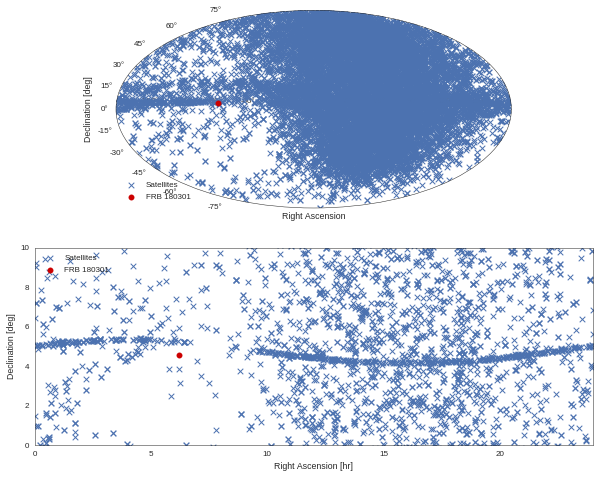

In [8]:
plt.figure(figsize=(10, 8))
plt.subplot(211, projection='mollweide')
plt.scatter(sat_loc['ra_ha'] / 57.3*15 - np.pi, sat_loc['dec_deg'] / 57.3, marker='x')
plt.scatter(frb_ra.value / 57.3*15 - np.pi, frb_dec.value  / 57.3, marker='o', color='#cc0000')
#plt.xlim(0, 24)
plt.xlabel("Right Ascension")
plt.ylabel("Declination [deg]")
plt.legend(['Satellites', 'FRB 180301'])

plt.subplot(212)
plt.scatter(sat_loc['ra_ha'], sat_loc['dec_deg'], marker='x')
plt.scatter(frb_ra.value, frb_dec.value, marker='o', color='#cc0000')
plt.xlim(0, 24)
plt.ylim(0, 10)
plt.xlabel("Right Ascension [hr]")
plt.ylabel("Declination [deg]")
plt.legend(['Satellites', 'FRB 180301'])

## Extract list of nearby satellites (pandas)

In [9]:
nearby_in_ra  = np.abs(df['ra_ha'] - frb_ra.value)< 0.15      # within 0.5 in hourangle
nearby_in_dec = np.abs(df['dec_deg'] - frb_dec.value) < 2.0   # Within 5 degrees 
nearby = df[np.logical_and(nearby_in_ra, nearby_in_dec)]

# Extract TLEs for the nearby satellites
nearby_tles = []
for sat_idx, row in nearby.iterrows():
    nearby_tles.append(sat_list[sat_idx])

# print nearby stuff
nearby

,name,ra_ha,dec_deg,az_rad,alt_rad,za_rad
7209,0 ARIANE 5 DEB (,6.218605,3.849033,0.803543,0.734728,0.836068
7999,0 NSS 11 (AAP-1),6.166759,5.267406,0.769219,0.722904,0.847892
13828,0 TIANLIAN 1-02,6.221275,5.946708,0.775195,0.704974,0.865822
16994,0 ARIANE 5 DEB (,6.232785,3.143948,0.817648,0.742229,0.828568


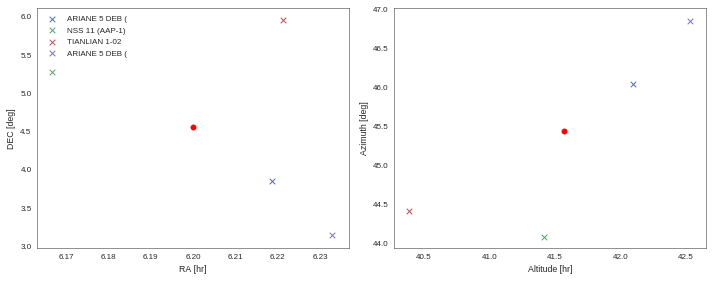

In [10]:
plt.figure(figsize=(10,4))
for idx, sat in nearby.iterrows():
    sname = sat['name'].lstrip('0 ')
    plt.subplot(1,2,1)
    plt.scatter(sat['ra_ha'], sat['dec_deg'], marker='x', label=sname)
    plt.subplot(1,2,2)
    plt.scatter(np.rad2deg(sat['alt_rad']), np.rad2deg(sat['az_rad']), marker='x', label=sname)
    
plt.subplot(1,2,1)   
plt.scatter(frb_ra.to('hourangle'), frb_dec.to('degree'), c='red')
plt.legend()
plt.xlabel("RA [hr]")
plt.ylabel("DEC [deg]")

plt.subplot(1,2,2)   
plt.scatter(frb_alt.to('degree'), frb_az.to('degree'), c='red')
plt.xlabel("Altitude [hr]")
plt.ylabel("Azimuth [deg]")

plt.tight_layout()

### Make trails in RA DEC space of satellites over 10 minutes

multibeam footprint stays the same, but satellites will move relative to it

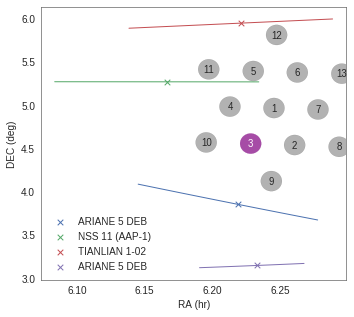

In [16]:
fig = plt.figure(figsize=(5.,4.5)) # (width, height)
ax = fig.add_subplot(1, 1, 1)

# Plot the location of the satellites when the FRB went off
for idx, sat in nearby.iterrows():
    sname = sat['name'].lstrip('0 ').rstrip(' (')
    plt.scatter(sat['ra_ha'], sat['dec_deg'], marker='x', label=sname)
    #plt.scatter(sat['ra_ha'].to('degree'), sat['dec_deg'], marker='x', label=sname)
    
# Plot satellite tracks -- iterate over +/- 5 minutes either side of the FRB
for sat in nearby_tles:
    sat_ras, sat_decs = [], []
    for t in range(34-5, 34+5):
        timestep =  datetime(2018, 3, 1, 7, t, 19, 76)
        pks.date = timestep
        sat.compute(pks)
        sat_ras.append(sat.ra)
        sat_decs.append(sat.dec)
    plt.plot(np.array(sat_ras) * 57.3/15, np.array(sat_decs) * 57.3)
    
# Plot beam footprint
for beam_id, beam in beam_dict.items():
    if beam_id == 3:
        ax.add_patch(patches.Ellipse((beam['ra'].to('hourangle').value, beam['dec'].to('degree').value),\
                                    14./60./15., 14./60., fill=True, color='purple', alpha=0.7))
        ax.text(beam['ra'].to('hourangle').value, beam['dec'].to('degree').value, beam_id,\
            horizontalalignment='center', verticalalignment='center', color='white')
    else:
        ax.add_patch(patches.Ellipse((beam['ra'].to('hourangle').value, beam['dec'].to('degree').value),\
                                    14./60./15., 14./60., fill=True, color='black', alpha=0.3))
        ax.text(beam['ra'].to('hourangle').value, beam['dec'].to('degree').value, beam_id,\
            horizontalalignment='center', verticalalignment='center')

ax.tick_params(labelsize=10)
        
plt.legend(fontsize=10)
plt.xlabel("RA (hr)", fontsize=10)
plt.ylabel("DEC (deg)", fontsize=10)

plt.tight_layout()
plt.savefig('satellite_paths.pdf')

### Sanity check: is a solar system object nearby

In [12]:
moon = ephem.Moon()
sun = ephem.Sun()
venus = ephem.Venus()
mars = ephem.Mars()
saturn = ephem.Saturn()
jupiter = ephem.Jupiter()
uranus = ephem.Uranus()
neptune = ephem.Neptune()

for src in [moon, sun, venus, mars, saturn, jupiter, uranus, neptune]:
    src.compute(pks)
    print src.name, src.ra, src.dec

Moon 10:17:47.68 12:59:52.0
Sun 22:48:36.33 -7:33:57.0
Venus 23:36:12.62 -4:03:22.0
Mars 17:18:28.95 -22:48:44.1
Saturn 18:31:44.91 -22:21:25.5
Jupiter 15:24:10.57 -17:24:20.0
Uranus 1:36:58.33 9:30:53.8
Neptune 23:01:44.14 -7:12:11.1
